In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path = '/content/drive/MyDrive/Dataset/GoogleStockPrices.csv'
df=pd.read_csv(path)

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-02 16:00:00,26.63,26.79,26.39,26.48,1327870
1,2015-01-05 16:00:00,26.36,26.40,25.89,25.97,2059119
2,2015-01-06 16:00:00,26.02,26.06,25.28,25.33,2731813
3,2015-01-07 16:00:00,25.55,25.57,25.18,25.26,2345875
4,2015-01-08 16:00:00,25.08,25.38,24.75,25.35,3662224


In [5]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2516 non-null   object 
 1   Open    2516 non-null   float64
 2   High    2516 non-null   float64
 3   Low     2516 non-null   float64
 4   Close   2516 non-null   float64
 5   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.1+ KB


In [7]:
# Data Normalization
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

df_scaled[features].describe()

,Open,High,Low,Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.335005,0.331900,0.336098,0.336796,0.070022
std,0.253738,0.250635,0.253812,0.254560,0.114742
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.130057,0.128267,0.131726,0.131133,0.007842
50%,0.229671,0.226943,0.231092,0.232000,0.011853
75%,0.549684,0.544371,0.551795,0.552063,0.046989
max,1.000000,1.000000,1.000000,1.000000,1.000000


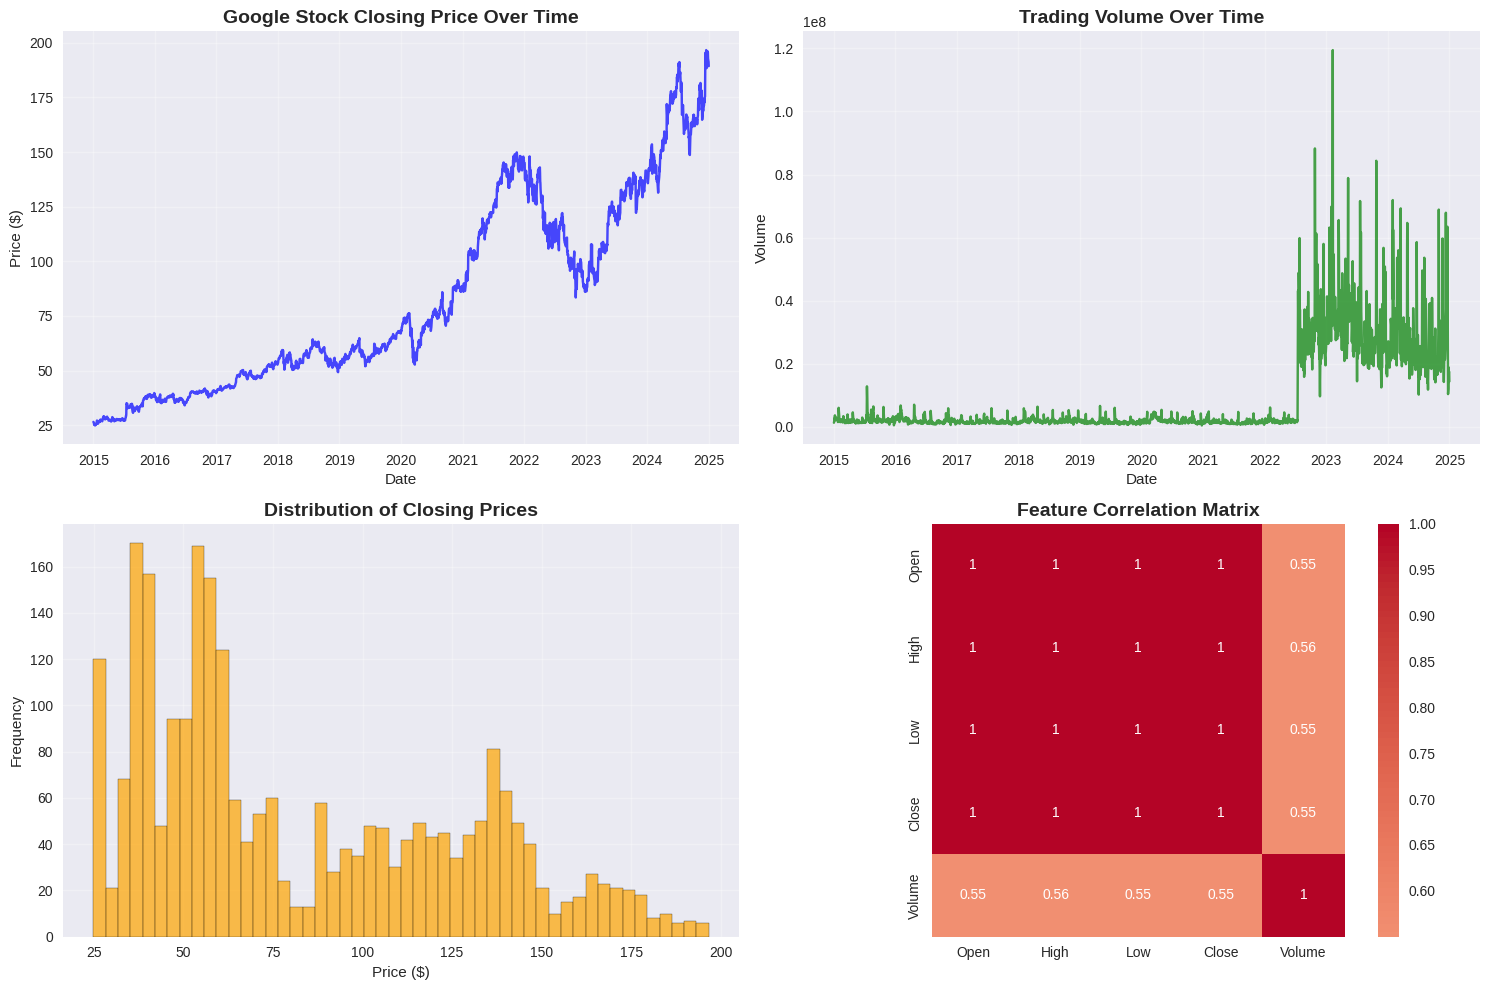

In [23]:
#Basic Visualization

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Stock price over time
axes[0, 0].plot(df['Date'], df['Close'], color='blue', alpha=0.7)
axes[0, 0].set_title('Google Stock Closing Price Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Volume over time
axes[0, 1].plot(df['Date'], df['Volume'], color='green', alpha=0.7)
axes[0, 1].set_title('Trading Volume Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# Price distribution
axes[1, 0].hist(df['Close'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Closing Prices', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Correlation heatmap
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# Preprocessing
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Parameters
SEQUENCE_LENGTH = 60  # Use 60 days to predict next day
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 100

# Prepare data for time series prediction (using Close price)
close_prices = df_scaled['Close'].values.reshape(-1, 1)

# Create sequences
X, y = create_sequences(close_prices, SEQUENCE_LENGTH)
print(f"Sequences shape: {X.shape}, Targets shape: {y.shape}")

Sequences shape: (2456, 60, 1), Targets shape: (2456, 1)


In [14]:
# Train-test split (80-20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# DataLoader
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create datasets and dataloaders
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Train set: (1964, 60, 1), Test set: (492, 60, 1)
Number of training batches: 62
Number of test batches: 16


In [15]:
# LSTM Model Definition

class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        # Initialize hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h_0, c_0))

        # Use the last output for prediction
        out = out[:, -1, :]

        # Linear layers
        out = self.linear(out)

        return out

# Initialize model
model = StockLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

print(f"Model architecture:\n{model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model architecture:
StockLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 52,545


In [16]:
# Training Loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_stock_model.pth')

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch [0/100], Train Loss: 0.007041, Val Loss: 0.154730
Epoch [10/100], Train Loss: 0.013324, Val Loss: 0.031305
Epoch [20/100], Train Loss: 0.001566, Val Loss: 0.006563
Epoch [30/100], Train Loss: 0.001229, Val Loss: 0.002539
Epoch [40/100], Train Loss: 0.001898, Val Loss: 0.001989
Epoch [50/100], Train Loss: 0.001801, Val Loss: 0.001538
Epoch [60/100], Train Loss: 0.001524, Val Loss: 0.000956
Epoch [70/100], Train Loss: 0.001508, Val Loss: 0.000802
Epoch [80/100], Train Loss: 0.001412, Val Loss: 0.000828
Epoch [90/100], Train Loss: 0.001318, Val Loss: 0.000558


In [17]:
# Load best model and make predictions
model.load_state_dict(torch.load('best_stock_model.pth'))
model.eval()

# Make predictions on test set
predictions = []
actuals = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predictions.extend(output.cpu().numpy())
        actuals.extend(target.cpu().numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Inverse transform to get actual prices
# Create dummy arrays with correct shape for inverse transform
predictions_dummy = np.zeros((len(predictions), len(features)))
actuals_dummy = np.zeros((len(actuals), len(features)))

# Place predictions in the 'Close' column position (index 3)
predictions_dummy[:, 3] = predictions.flatten()  # Close is at index 3
actuals_dummy[:, 3] = actuals.flatten()

# Inverse transform
predictions_rescaled = scaler.inverse_transform(predictions_dummy)[:, 3]
actuals_rescaled = scaler.inverse_transform(actuals_dummy)[:, 3]

In [18]:
# Calculate metrics
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_rescaled, predictions_rescaled)

print(f"\n=== Model Performance Metrics ===")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


=== Model Performance Metrics ===
MSE: 16.1579
MAE: 3.0130
RMSE: 4.0197
R² Score: 0.9774


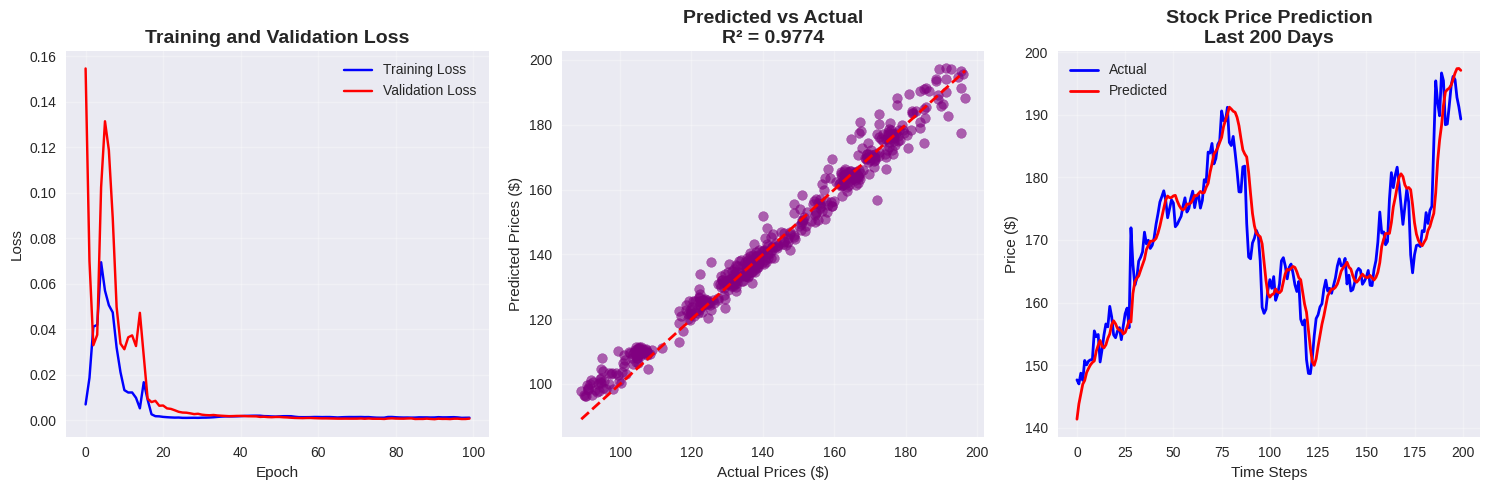

In [19]:
# Plotting Results

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictions vs Actuals
plt.subplot(1, 3, 2)
plt.scatter(actuals_rescaled, predictions_rescaled, alpha=0.6, color='purple')
plt.plot([actuals_rescaled.min(), actuals_rescaled.max()],
         [actuals_rescaled.min(), actuals_rescaled.max()], 'r--', lw=2)
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.title(f'Predicted vs Actual\nR² = {r2:.4f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Time series comparison
plt.subplot(1, 3, 3)
n_points = min(200, len(predictions_rescaled))
plt.plot(actuals_rescaled[-n_points:], label='Actual', color='blue', linewidth=2)
plt.plot(predictions_rescaled[-n_points:], label='Predicted', color='red', linewidth=2)
plt.title(f'Stock Price Prediction\nLast {n_points} Days', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



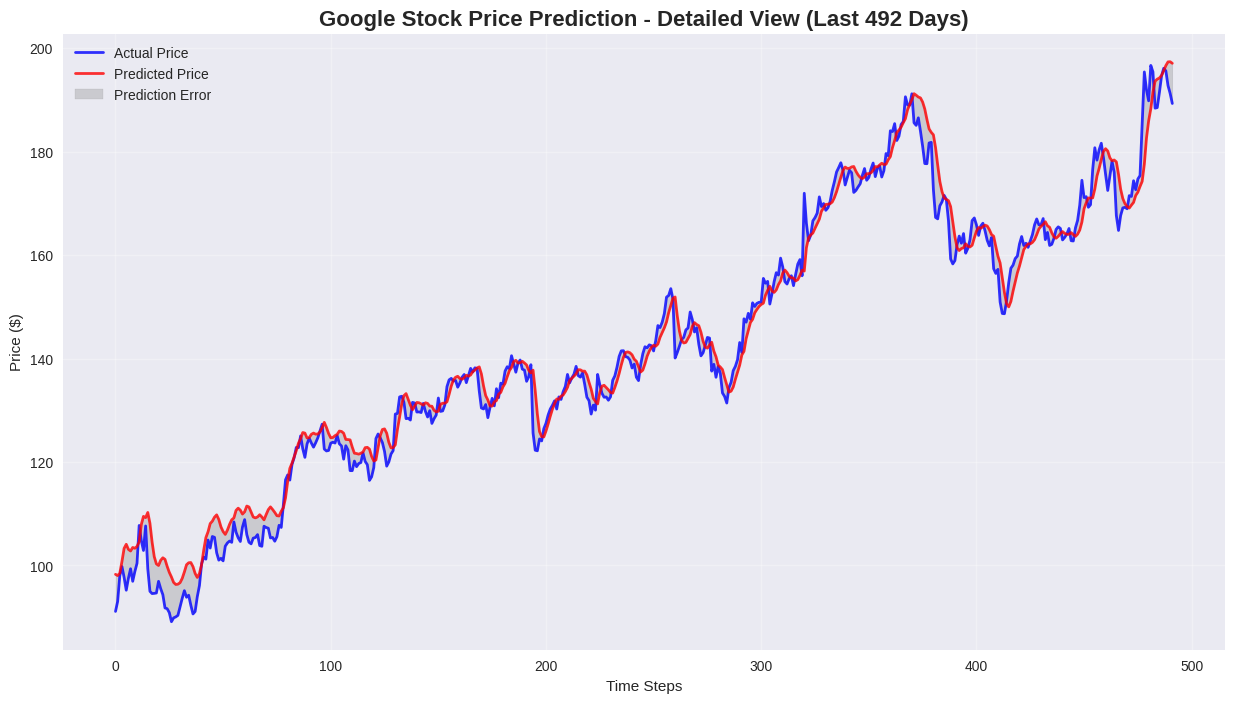

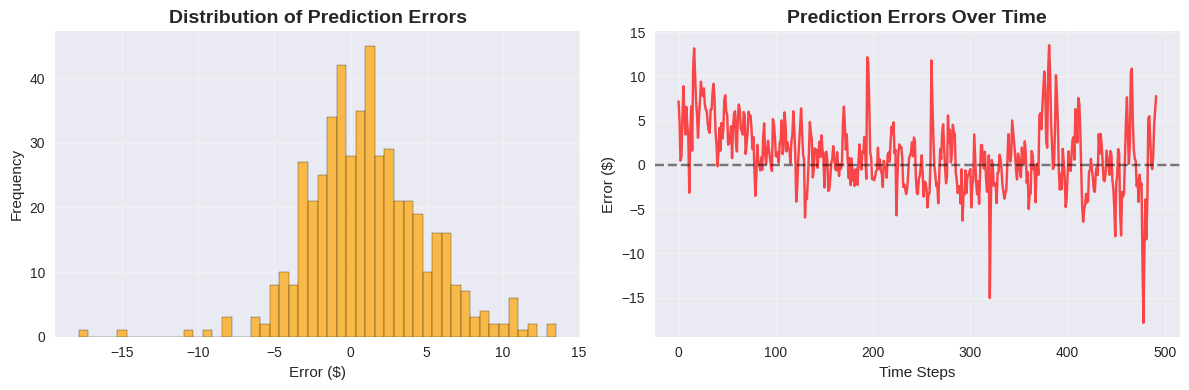

In [20]:
# Detailed time series comparison
plt.figure(figsize=(15, 8))
n_detailed = min(500, len(predictions_rescaled))
plt.plot(actuals_rescaled[-n_detailed:], label='Actual Price', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_rescaled[-n_detailed:], label='Predicted Price', color='red', linewidth=2, alpha=0.8)
plt.fill_between(range(len(actuals_rescaled[-n_detailed:])),
                 actuals_rescaled[-n_detailed:], predictions_rescaled[-n_detailed:],
                 alpha=0.3, color='gray', label='Prediction Error')
plt.title(f'Google Stock Price Prediction - Detailed View (Last {n_detailed} Days)', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Error analysis
errors = predictions_rescaled - actuals_rescaled
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(errors, color='red', alpha=0.7)
plt.title('Prediction Errors Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Error ($)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
torch.save(model.state_dict(), "best_stock_model.pth")